In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import statsmodels.formula.api as smf
from textblob import TextBlob
import re
import json

Dataset Loading and Data Cleaning

In [203]:
#Read the files
normal_reviews = pd.read_csv('outcomes/relevant_reviews.csv')  
not_recommended = pd.read_csv('outcomes/not-recommended-reviews.csv') 

In [204]:
print(f'The dataset contains {len(normal_reviews)} normal reviews and {len(not_recommended)} not recommended reviews')
print(f'there are {normal_reviews["business_id"].nunique()} unique businesses in the dataset')
print()  

print(f"First normal-review-date: {normal_reviews['date'].min()}")
print(f"Last normal-review-date: {normal_reviews['date'].max()}")

The dataset contains 82982 normal reviews and 9683 not recommended reviews
there are 505 unique businesses in the dataset

First normal-review-date: 2005-02-16 04:06:26
Last normal-review-date: 2022-01-19 18:05:57


In [205]:
#Drop review id, 'useful', 'funny', 'cool. I dont think we need it.
normal_reviews = normal_reviews.drop(['useful','review_id', 'funny','cool', 'user_id'], axis=1)

In [206]:
#Fix the date format.
normal_reviews['date'] = pd.to_datetime(normal_reviews['date'])

not_recommended['review_date'] = not_recommended['review_date'].str.split('\n').str[0]
not_recommended['review_date'] = pd.to_datetime(not_recommended['review_date'], format='%d.%m.%Y', errors='coerce')

In [207]:
#Fix the textual content (should facilitate TextBlob)
def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')

    return text

# Apply cleaning function to the DataFrame
normal_reviews['text'] = normal_reviews['text'].apply(clean_text)

In [208]:
#Starting dataset normal reviews after cleaning
normal_reviews.head(5)

,business_id,stars,text,date
0,RZtGWDLCAtuipwaZ-UfjmQ,4,good food--loved the gnocchi with marinara the...,2009-10-14 19:57:14
1,TttFjRQ-8Iz8by4hsD7iOQ,5,last night we tried to get into the oldest ita...,2017-11-06 17:26:43
2,1NCUTTp6rIyXpwUDVv9qOA,2,i had to write an order after coming here a co...,2016-06-22 21:51:03
3,u7_3L1NBWgxhBM_B-cmmnA,4,this amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27
4,CinrOH8rMB2hEvPY_iFOHA,1,"i really wanted to like casselli's, but it was...",2009-03-02 02:05:49


In [209]:
#Starting dataset not-recommended reviews
not_recommended.head(5)

,business_id,user_name,user_location,has_image,friends_count,reviews_count,photos_count,rating,review_date,language,review_text
0,QdN72BWoyFypdGJhhI5r7g,C C.,"Philadelphia, Vereinigte Staaten",False,0,1,0,1.0 Sterne,2016-11-06,en,"Totally dissapionted and a big boo!, Maybe the..."
1,QdN72BWoyFypdGJhhI5r7g,Edward M.,"Philadelphia, Vereinigte Staaten",False,0,13,0,2.0 Sterne,2019-06-30,en,Pros: good food. Decent drinks. Nice neighborh...
2,QdN72BWoyFypdGJhhI5r7g,Isabel W.,"Mercer Island, Vereinigte Staaten",False,65,59,1 Foto,3.0 Sterne,2019-06-02,en,"Good, honey bar, but it hardly ever has dark b..."
3,QdN72BWoyFypdGJhhI5r7g,Katherine T.,"Camden County, Vereinigte Staaten",False,308,3,0,5.0 Sterne,2019-07-12,en,Phenomenal customer service. Jules is amazing....
4,QdN72BWoyFypdGJhhI5r7g,Jay M.,"Millstone, Vereinigte Staaten",True,187,2,0,5.0 Sterne,2017-02-09,en,"Great food, great service. Best happy hour aro..."


ANALYZING DATA PRE-TREATMENT

In [210]:
#select a cut_off date
cut_off_date = pd.to_datetime("2013-11-14")

#select time delta to define pre- post- periods 
time_delta = pd.Timedelta(weeks=12)

12 weeks pre-treat contains: 1655 normal revies and 228 not recommended reviews
q1 1.0 is q4 is 7.0


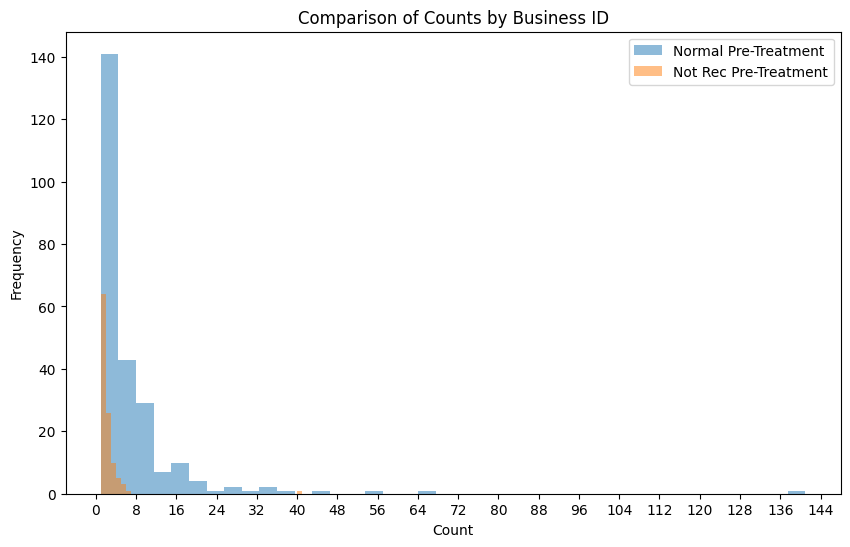

In [234]:
#check distribution of the not-recommended in pre-treatment  (q1-q4)

start_date_pre = cut_off_date - time_delta

#select only reviews in the time_delta range
#between start_data and cut_off_date
normal_pre_treat = normal_reviews[(normal_reviews['date'] >= start_date_pre) & (normal_reviews['date'] <= cut_off_date)]
not_rec_pre_treat = not_recommended[(not_recommended['review_date'] >= start_date_pre) & (not_recommended['review_date'] <= cut_off_date)]

print(f'12 weeks pre-treat contains: {len(normal_pre_treat)} normal revies and {len(not_rec_pre_treat)} not recommended reviews')

#group by business_id
group_pre_treatment_normal = normal_pre_treat.groupby(by='business_id').size().reset_index(name='count')
group_pre_treatment_not_rec = not_rec_pre_treat.groupby(by='business_id').size().reset_index(name='count')

#plot
plt.figure(figsize=(10, 6))

plt.hist(group_pre_treatment_normal['count'], bins=40, alpha=0.5, label='Normal Pre-Treatment')
plt.hist(group_pre_treatment_not_rec['count'], bins=40, alpha=0.5, label='Not Rec Pre-Treatment')

plt.title('Comparison of Counts by Business ID')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend()

ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=20)) 

q1 = group_pre_treatment_normal['count'].quantile(0.25)
q4 = group_pre_treatment_normal['count'].quantile(0.75)

print(f"q1 {q1} is q4 is {q4}")

PREPARING DATA FOR DIFFERENCE IN DIFFERENCE

In [212]:
#DECIDE IF REVIEWS ARE DONE BEFORE OR AFTER CUT_OFF_DATE

#decide if the reviews are pre or post cut_off_date (0 pre - 1 post) (Change Dummy)
normal_reviews['cut_off_date'] = (normal_reviews['date'] >= cut_off_date).astype(int)
not_recommended['cut_off_date'] = (not_recommended['review_date'] >= cut_off_date).astype(int)

normal_reviews.head()

,business_id,stars,text,date,cut_off_date
0,RZtGWDLCAtuipwaZ-UfjmQ,4,good food--loved the gnocchi with marinara the...,2009-10-14 19:57:14,0
1,TttFjRQ-8Iz8by4hsD7iOQ,5,last night we tried to get into the oldest ita...,2017-11-06 17:26:43,1
2,1NCUTTp6rIyXpwUDVv9qOA,2,i had to write an order after coming here a co...,2016-06-22 21:51:03,1
3,u7_3L1NBWgxhBM_B-cmmnA,4,this amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27,1
4,CinrOH8rMB2hEvPY_iFOHA,1,"i really wanted to like casselli's, but it was...",2009-03-02 02:05:49,0


In [213]:
#COUNT amount of  normal PRE and POST change (whole dataset, not only -12 cut_off +12 cut_off)

#Get total number of normal reviews PRE CUTOFF DATE --> #3316
count_normal_reviews_pre = len(normal_reviews[normal_reviews['cut_off_date'] == 0])
#Get total number of not recommended reviews POST CUTOFF DATE --> #6367
count_normal_reviews_after = len(normal_reviews[normal_reviews['cut_off_date'] == 1])

#Get total number of not recommended reviews PRE CUTOFF DATE --> #3316
count_not_rec_reviews_pre = len(not_recommended[not_recommended['cut_off_date'] == 0])
#Get total number of not recommended reviews POST CUTOFF DATE --> #6367
count_not_rec_reviews_after = len(not_recommended[not_recommended['cut_off_date'] == 1])


print(f"Total normal reviews {count_normal_reviews_pre + count_normal_reviews_after} (whole dataset)")
print(f"Total normal reviews PRE CUTOFF DATE: {count_normal_reviews_pre}, POST CUTOFF DATE: {count_normal_reviews_after}")

print(f"Total not recommended reviews {count_not_rec_reviews_after + count_not_rec_reviews_pre} (whole dataset)")
print(f"Total not recommended reviews PRE CUTOFF DATE: {count_not_rec_reviews_pre}, POST CUTOFF DATE: {count_not_rec_reviews_after}")

Total normal reviews 82982 (whole dataset)
Total normal reviews PRE CUTOFF DATE: 25833, POST CUTOFF DATE: 57149
Total not recommended reviews 9683 (whole dataset)
Total not recommended reviews PRE CUTOFF DATE: 3316, POST CUTOFF DATE: 6367


In [214]:
#CREATE TOTAL NUMBER OF NOT_RECOMMENDED_TILL_CUT_OFF_DATE

#Discard everything after cut_off_date
business_id_number_not_rec = not_recommended[not_recommended['cut_off_date'] == 0] 

#Group by business id and count number of reviews before policy change
business_id_number_not_rec = business_id_number_not_rec.groupby('business_id').size().reset_index(name='not_recommended_review_count_pre') 

In [215]:
#ADD not_recommended_review_count_pre to the normal reviews

#Join this with every review in the normal-review-dataset
merged_data_updated = pd.merge(normal_reviews, business_id_number_not_rec, on='business_id', how='left')
merged_data_updated['not_recommended_review_count_pre'] = merged_data_updated['not_recommended_review_count_pre'].fillna(0)

merged_data_updated.head()

,business_id,stars,text,date,cut_off_date,not_recommended_review_count_pre
0,RZtGWDLCAtuipwaZ-UfjmQ,4,good food--loved the gnocchi with marinara the...,2009-10-14 19:57:14,0,9.0
1,TttFjRQ-8Iz8by4hsD7iOQ,5,last night we tried to get into the oldest ita...,2017-11-06 17:26:43,1,0.0
2,1NCUTTp6rIyXpwUDVv9qOA,2,i had to write an order after coming here a co...,2016-06-22 21:51:03,1,6.0
3,u7_3L1NBWgxhBM_B-cmmnA,4,this amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27,1,4.0
4,CinrOH8rMB2hEvPY_iFOHA,1,"i really wanted to like casselli's, but it was...",2009-03-02 02:05:49,0,2.0


In [216]:
#CONTROL OR TREATMENT?
#Focus on q1 (bottom 25% of number of not recommended) for control group and q4 (top 25% of number of not recommended) for treatment group
#Remove those in q2 and q3

unique_restaurants_df = merged_data_updated.drop_duplicates(subset='business_id', keep='first')

q1_value = unique_restaurants_df['not_recommended_review_count_pre'].quantile(0.25) #0 -> try change this
q4_value = unique_restaurants_df['not_recommended_review_count_pre'].quantile(0.75) #8


merged_data_updated = merged_data_updated[
    (merged_data_updated['not_recommended_review_count_pre'] <= q1_value) |
    (merged_data_updated['not_recommended_review_count_pre'] >= q4_value)
]

In [217]:
#ADD TREATMENT OR CONTROL BINARY

merged_data_updated['treatment'] = merged_data_updated['not_recommended_review_count_pre'].apply(
    lambda x: 0 if x <= q1_value else 1)

#4. how many restaurants?
control_group_count = merged_data_updated[merged_data_updated['treatment'] == 0]['business_id'].nunique()
treatment_group_count = merged_data_updated[merged_data_updated['treatment'] == 1]['business_id'].nunique()


print(f"Control Group: {control_group_count} businesses, Treatment Group: {treatment_group_count} businesses")

Control Group: 188 businesses, Treatment Group: 140 businesses


In [218]:
merged_data_updated.head()

,business_id,stars,text,date,cut_off_date,not_recommended_review_count_pre,treatment
0,RZtGWDLCAtuipwaZ-UfjmQ,4,good food--loved the gnocchi with marinara the...,2009-10-14 19:57:14,0,9.0,1
1,TttFjRQ-8Iz8by4hsD7iOQ,5,last night we tried to get into the oldest ita...,2017-11-06 17:26:43,1,0.0,0
5,rVfe1LHo55A2fworkm_jVw,5,"originally, our little group headed to frankli...",2017-04-30 20:36:07,1,0.0,0
6,wUnLSg_GKfEIQ5CQQ770_g,5,i highly recommend this place! this was our fi...,2017-02-20 02:14:55,1,24.0,1
8,j99PtxlKTW_u5alE4jiqHQ,5,went here with my boyfriend and we loved it! o...,2011-10-27 21:45:26,0,16.0,1


In [219]:
#ADD COLUMN FOR LENGHT OF TEXT-REVIEW
merged_data_updated['text_length'] = merged_data_updated['text'].apply(len)

merged_data_updated.head()

,business_id,stars,text,date,cut_off_date,not_recommended_review_count_pre,treatment,text_length
0,RZtGWDLCAtuipwaZ-UfjmQ,4,good food--loved the gnocchi with marinara the...,2009-10-14 19:57:14,0,9.0,1,175
1,TttFjRQ-8Iz8by4hsD7iOQ,5,last night we tried to get into the oldest ita...,2017-11-06 17:26:43,1,0.0,0,559
5,rVfe1LHo55A2fworkm_jVw,5,"originally, our little group headed to frankli...",2017-04-30 20:36:07,1,0.0,0,415
6,wUnLSg_GKfEIQ5CQQ770_g,5,i highly recommend this place! this was our fi...,2017-02-20 02:14:55,1,24.0,1,197
8,j99PtxlKTW_u5alE4jiqHQ,5,went here with my boyfriend and we loved it! o...,2011-10-27 21:45:26,0,16.0,1,515


In [220]:
#ADD LOGIC FOR SENTIMENTAL ANALYSIS (package is texblob, rating from -1 to 1)
#This is also slow, no idea why.

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

merged_data_updated['sentiment_score'] = round(merged_data_updated['text'].apply(get_sentiment), 4)

merged_data_updated.head(5)

,business_id,stars,text,date,cut_off_date,not_recommended_review_count_pre,treatment,text_length,sentiment_score
0,RZtGWDLCAtuipwaZ-UfjmQ,4,good food--loved the gnocchi with marinara the...,2009-10-14 19:57:14,0,9.0,1,175,0.3840
1,TttFjRQ-8Iz8by4hsD7iOQ,5,last night we tried to get into the oldest ita...,2017-11-06 17:26:43,1,0.0,0,559,0.0250
5,rVfe1LHo55A2fworkm_jVw,5,"originally, our little group headed to frankli...",2017-04-30 20:36:07,1,0.0,0,415,0.2634
6,wUnLSg_GKfEIQ5CQQ770_g,5,i highly recommend this place! this was our fi...,2017-02-20 02:14:55,1,24.0,1,197,0.5454
8,j99PtxlKTW_u5alE4jiqHQ,5,went here with my boyfriend and we loved it! o...,2011-10-27 21:45:26,0,16.0,1,515,0.5631


In [221]:
#merged_data_updated['did_dummy'] = merged_data_updated['cut_off_date'] * merged_data_updated['treatment']
#merged_data_updated = merged_data_updated.rename('review_id')

desired_order = ['business_id', 'date', 'stars', 'text', 'cut_off_date', 'not_recommended_review_count_pre', 'treatment', 'text_length', 'sentiment_score',]
merged_data_updated = merged_data_updated[desired_order]

merged_data_updated.head(5)

,business_id,date,stars,text,cut_off_date,not_recommended_review_count_pre,treatment,text_length,sentiment_score
0,RZtGWDLCAtuipwaZ-UfjmQ,2009-10-14 19:57:14,4,good food--loved the gnocchi with marinara the...,0,9.0,1,175,0.3840
1,TttFjRQ-8Iz8by4hsD7iOQ,2017-11-06 17:26:43,5,last night we tried to get into the oldest ita...,1,0.0,0,559,0.0250
5,rVfe1LHo55A2fworkm_jVw,2017-04-30 20:36:07,5,"originally, our little group headed to frankli...",1,0.0,0,415,0.2634
6,wUnLSg_GKfEIQ5CQQ770_g,2017-02-20 02:14:55,5,i highly recommend this place! this was our fi...,1,24.0,1,197,0.5454
8,j99PtxlKTW_u5alE4jiqHQ,2011-10-27 21:45:26,5,went here with my boyfriend and we loved it! o...,0,16.0,1,515,0.5631


ANALYSIS OF THE DATA (GRAPHS)

In [222]:
#REDUCE ONLY TO +/- CUT_OFF PERIOD

start_date = cut_off_date - time_delta
end_date = cut_off_date + time_delta

#select only reviews in the time_delta range
filtered_data = merged_data_updated[(merged_data_updated['date'] >= start_date) & (merged_data_updated['date'] <= end_date)]

print(f"Control Reviews: {len(filtered_data[filtered_data['treatment']==0])} Treament Reviews {len(filtered_data[filtered_data['treatment']==1])}")

Control Reviews: 112 Treament Reviews 2359


In [223]:
#total number of normal reviews
print(f"Reviews in the 24-week window: {len(filtered_data)}")
print()

#total number of normal reviews pre
print(f"Reviews in the pre-treatment window: {len(filtered_data[filtered_data['treatment'] == 0])}")
print(f"Total Business in pre-treatment window: {filtered_data[filtered_data['treatment'] == 0]['business_id'].nunique()}")

print()

#total nubmer of normal reviews after
print(f"Reviews in the post-treatment window: {len(filtered_data[filtered_data['treatment'] == 1])}")
print(f"Total Business in post-treatment window: {filtered_data[filtered_data['treatment'] == 1]['business_id'].nunique()}")

print()
      
#print number of unique restaurants in the pre + post time window.
print(f'Unique restaurants in the 24 time window: {filtered_data["business_id"].nunique("business_id")}')


Reviews in the 24-week window: 2471

Reviews in the pre-treatment window: 112
Total Business in pre-treatment window: 25

Reviews in the post-treatment window: 2359
Total Business in post-treatment window: 125

Unique restaurants in the 24 time window: 150


In [224]:
filtered_data.head()
filtered_data.to_csv('outcomes/fitlered_data.csv')

In [225]:

#average_review_length=('text_length', 'mean'), #de-group
#average_average_score=('stars', 'mean')  # de-group

#group by - business_id - 'treatmen' - 'pediod' and doing the means
review_counts_period = filtered_data.groupby(['business_id', 'treatment', 'cut_off_date']).agg(
    review_count=('business_id', 'size'), #smaller aggregation, maybe for each week,
).reset_index()


In [226]:
#PROBLEM: SOME BUSINESSES ARE IN 0 BUT NOT IN ONE OR THE OTHER WAY AROUND 
print(review_counts_period[(review_counts_period["treatment"] == 0) & (review_counts_period["cut_off_date"] == 0)]['business_id'].nunique())
print(review_counts_period[(review_counts_period["treatment"] == 0) & (review_counts_period["cut_off_date"] == 1)]['business_id'].nunique())


13
23


In [227]:
#create a dataset containing containing the 4 different combination (0, before - 0, after - 1, before - 1, after)
#tehy are stored as tuples, [0] is the dataset['count]  [1] is the title for the graphs
#datasets = []
#for treatment in (0, 1):  
#    for cut_off in (0,):
#        subset = review_counts_period[(review_counts_period['treatment'] == treatment) & (review_counts_period['cut_off_date'] == cut_off)]
#        datasets.append((subset['review_count'], f"{'Treatment' if treatment else 'Control'} {cut_off}")) #append only the count

datasets = []
for treatment in (0, 1):
    for cut_off in (0, 1):  
        subset = review_counts_period[(review_counts_period['treatment'] == treatment) & (review_counts_period['cut_off_date'] == cut_off)]
        title = f"{'Treatment' if treatment else 'Control'} - {'After' if cut_off else 'Before'}"
        datasets.append((subset, title))


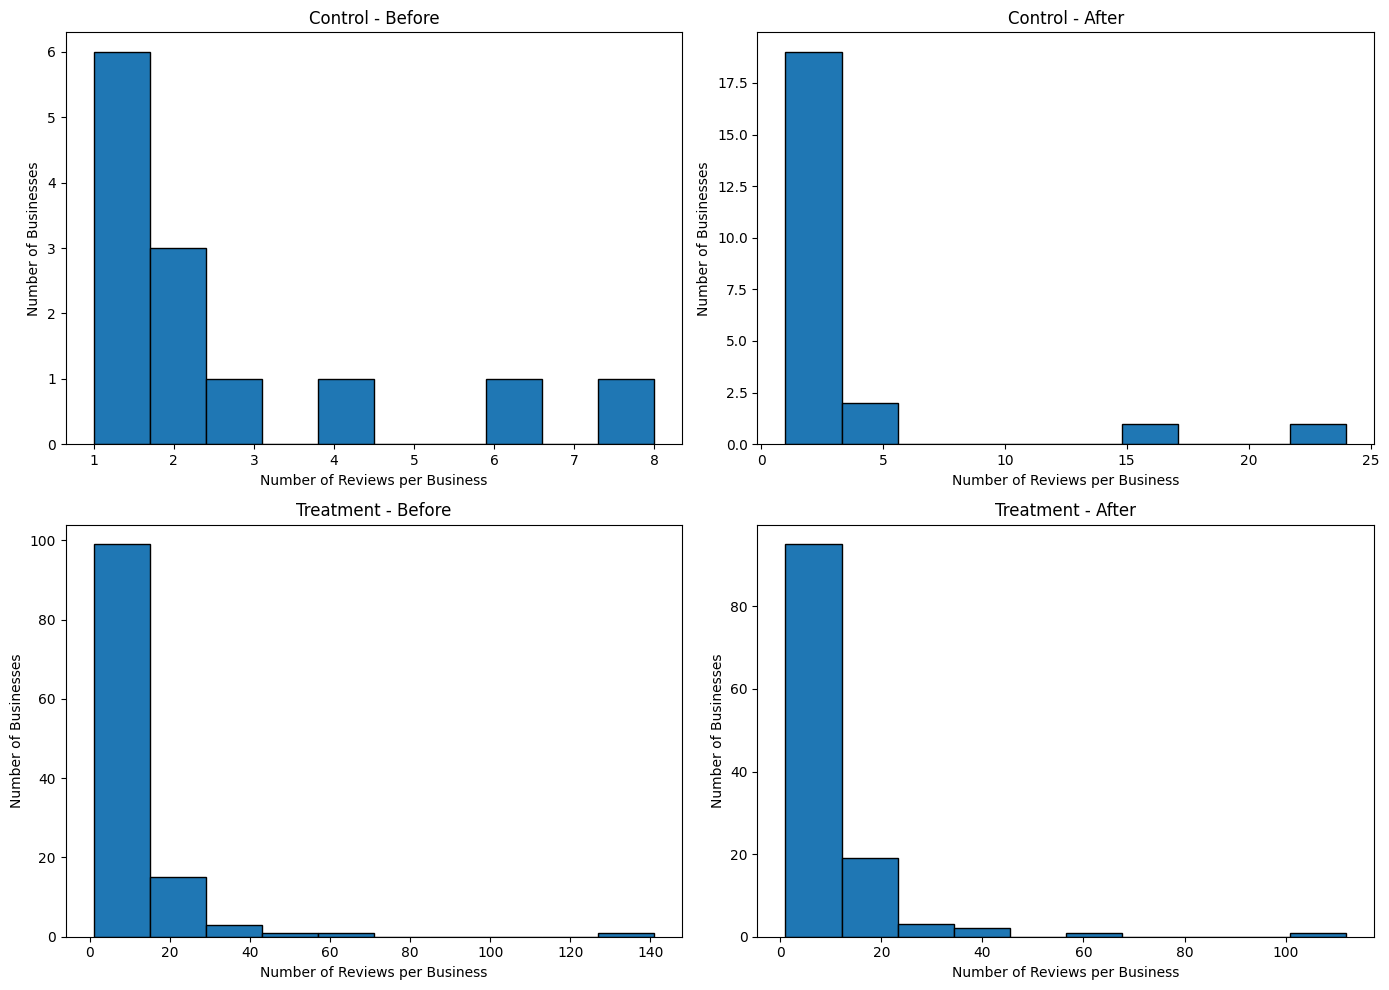

In [228]:
#plot the graphs
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for idx, (data, title) in enumerate(datasets):
    if 'review_count' in data.columns:
        axs[idx].hist(data['review_count'], bins=10, edgecolor='black')
        # Optionally, set specific locator settings here if needed
        # axs[idx].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        axs[idx].set_title(title)
        axs[idx].set_xlabel('Number of Reviews per Business')
        axs[idx].set_ylabel('Number of Businesses')
    else:
        axs[idx].text(0.5, 0.5, 'No review_count data available', ha='center', va='center')
        axs[idx].set_title(title)

plt.tight_layout()
plt.show()

In [229]:
#for period in ('before', 'after'):
#    subset_statistic = filtered_data[filtered_data['period'] == period]
#    print(f"Statistics for {period}: "
#          f"score: {subset_statistic['stars'].mean()}, "
#          f"textual_length: {subset_statistic['text_length'].mean()}, "
#          f"sentiment_score: {subset_statistic['sentiment_score'].mean()}")

In [230]:
# H1:  A high number of 'not recommended' reviews decrease future sales to the restaurant.

#filter also by year/week
filtered_data['year'] = filtered_data['date'].dt.year
filtered_data['week_number'] = filtered_data['date'].dt.isocalendar().week

review_counts_by_week = filtered_data.groupby(['business_id', 'treatment', 'cut_off_date', 'year', 'week_number']).agg(
    review_count=('business_id', 'size') # Aggregation for review counts
).reset_index()

formula = 'review_count ~ treatment + cut_off_date + treatment:cut_off_date'

# Fit the regression model using OLS with the direct interaction term in the formula
model = smf.ols(formula=formula, data=review_counts_by_week).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.644
Date:                Thu, 15 Feb 2024   Prob (F-statistic):             0.0123
Time:                        19:59:15   Log-Likelihood:                -2611.5
No. Observations:                1391   AIC:                             5231.
Df Residuals:                    1387   BIC:                             5252.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

/var/folders/_v/_hbrmw9n4qjdtrf9w3730x680000gn/T/ipykernel_37942/2564536483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year'] = filtered_data['date'].dt.year
/var/folders/_v/_hbrmw9n4qjdtrf9w3730x680000gn/T/ipykernel_37942/2564536483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['week_number'] = filtered_data['date'].dt.isocalendar().week


In [231]:

# H2:  A high number of ‚not recommended’ reviews decreases the rating score of future reviews.
# Define the regression formula with an interaction term included directly
formula = 'stars ~ treatment + cut_off_date + treatment:cut_off_date'

# Fit the regression model using OLS with the direct interaction term in the formula
model = smf.ols(formula=formula, data=filtered_data).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.163
Date:                Thu, 15 Feb 2024   Prob (F-statistic):             0.0236
Time:                        19:59:15   Log-Likelihood:                -4074.7
No. Observations:                2471   AIC:                             8157.
Df Residuals:                    2467   BIC:                             8181.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

In [232]:
#H3: Textual sentiment decreases for 1- and 2-star reviews when the number of ‚not recommended’ reviews is high.

#filter only reviews with 1 or 2 stars
filtered_data = filtered_data[filtered_data['stars'] <= 2]

formula = 'sentiment_score ~ treatment + cut_off_date + treatment:cut_off_date'

# Fit the regression model using OLS with the direct interaction term in the formula
model = smf.ols(formula=formula, data=filtered_data).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5802
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.628
Time:                        19:59:15   Log-Likelihood:                 124.00
No. Observations:                 456   AIC:                            -240.0
Df Residuals:                     452   BIC:                            -223.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

In [233]:
#H4: Textual sentiment increases for 4- and 5-star reviews when the number of ‚not recommended’ reviews is high.

#filter only reviews with 1 or 2 stars
#filtered_data = filtered_data[filtered_data['stars'] > 2]

#formula = 'sentiment_score ~ treatment + cut_off_date + treatment:cut_off_date'

# Fit the regression model using OLS with the direct interaction term in the formula
#model = smf.ols(formula=formula, data=filtered_data).fit()

# Print the summary of the regression model
#print(model.summary())

ValueError: zero-size array to reduction operation maximum which has no identity